In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rich import print
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

from aifeel.model.nn import NNClassifier
from aifeel.util import gen_dataframe, read_corpus
from aifeel.util.feature_extraction import extract_features, feature_to_vector
from aifeel.util.preprocess import preprocess_text

In [140]:
negative_corpus, positive_corpus = read_corpus("negative-reviews"), read_corpus(
    "positive-reviews"
)
negative_words, positive_words = set(read_corpus("negative-words")), set(
    read_corpus("positive-words")
)

In [141]:

df = gen_dataframe(positive_corpus, negative_corpus, random_state=42)
df["clean_review"] = df["review"].apply(preprocess_text)


In [142]:
base_feature_count = 1000
extra_feature_count = 2
feature_count = base_feature_count - (6 + extra_feature_count) # 6 primary features + 2 extra features
cv = CountVectorizer(max_features=feature_count)  # 6 primary features + 2 extra features
cv.fit(df["clean_review"])

CountVectorizer(max_features=992)

In [143]:


def vectorizer(review):
    result = cv.transform([review])
    return result.toarray()[0].tolist() # type: ignore
    #        ^      ^          ^
    #   spmatrix ndarray    list
    # it definitely exists, type hinter is just bad


In [144]:


df["features"] = df["clean_review"].apply(
    extract_features, args=(positive_words, negative_words), vectorizer=vectorizer
)
df["feature_vector"] = df["features"].apply(feature_to_vector, vectorizer=True)

In [145]:
X = np.array(df["feature_vector"].tolist())
y = np.array(df["tag"].tolist(), dtype=np.int32)

In [146]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [147]:
model = NNClassifier(input_dim=base_feature_count, epochs=10, batch_size=32, lr=0.0001)

In [148]:
model.fit(X_train, y_train)

Epoch 1/10
900/900 [==============================] - 5s 5ms/step - loss: 0.3307 - accuracy: 0.8597 - val_loss: 0.2069 - val_accuracy: 0.9197
Epoch 2/10
900/900 [==============================] - 5s 5ms/step - loss: 0.1955 - accuracy: 0.9218 - val_loss: 0.1791 - val_accuracy: 0.9369
Epoch 3/10
900/900 [==============================] - 5s 5ms/step - loss: 0.1724 - accuracy: 0.9324 - val_loss: 0.1695 - val_accuracy: 0.9388
Epoch 4/10
900/900 [==============================] - 5s 5ms/step - loss: 0.1581 - accuracy: 0.9384 - val_loss: 0.1636 - val_accuracy: 0.9409
Epoch 5/10
900/900 [==============================] - 5s 5ms/step - loss: 0.1488 - accuracy: 0.9421 - val_loss: 0.1645 - val_accuracy: 0.9413
Epoch 6/10
900/900 [==============================] - 5s 5ms/step - loss: 0.1381 - accuracy: 0.9470 - val_loss: 0.1621 - val_accuracy: 0.9434
Epoch 7/10
900/900 [==============================] - 5s 6ms/step - loss: 0.1300 - accuracy: 0.9501 - val_loss: 0.1616 - val_accuracy: 0.9422
Epoch 

In [149]:
y_pred = model.predict(X_test)

250/250 [==============================] - 0s 2ms/step


In [150]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.92      0.95      0.94      4000
           1       0.95      0.92      0.94      4000

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000

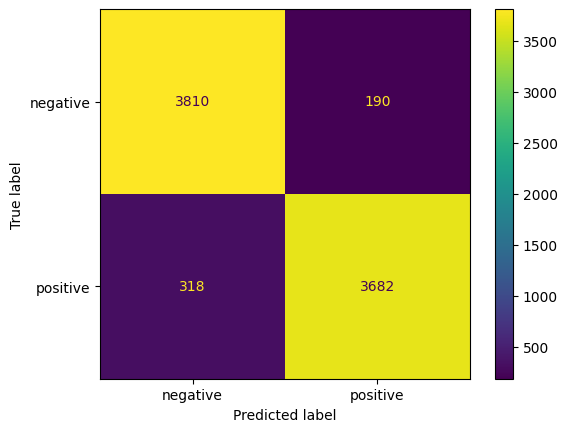

In [151]:

conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["negative", "positive"])

disp.plot()
plt.show()

In [152]:
test_reviews = [
    "I hate this movie",
    "Not bad",
    "No bad",
    "I like this movie",
    "damn this movie so good, i want all the actors in this movie to fucking jump off a cliff, refund my time lil bro",
    "skill issue",
]

test_reviews = [preprocess_text(review) for review in test_reviews]
test_reviews = [extract_features(review, positive_words, negative_words, vectorizer=vectorizer) for review in test_reviews]
test_reviews = np.array([feature_to_vector(review, vectorizer=True) for review in test_reviews])

print(model.predict_proba(test_reviews))

1/1 [==============================] - 0s 63ms/step
[[[0, 0.54860413], [1, 0.4513959]], [[0, 0.96334743], [1, 0.036652584]], [[0, 0.9497369], [1, 0.05026312]], [[0, 0.20429558], [1, 0.7957044]], [[0, 0.019560218], [1, 0.9804398]], [[0, 0.7129903], [1, 0.28700972]]]


[[[0.         0.54860413]
  [1.         0.4513959 ]]

 [[0.         0.96334743]
  [1.         0.03665258]]

 [[0.         0.94973689]
  [1.         0.05026312]]

 [[0.         0.20429558]
  [1.         0.79570442]]

 [[0.         0.01956022]
  [1.         0.98043978]]

 [[0.         0.71299028]
  [1.         0.28700972]]]

In [170]:
import os
from pathlib import Path

export_base = Path("export/model/NNClassifier")


if not os.path.exists(export_base):
    export_base.mkdir(parents=True, exist_ok=True)

In [171]:
model.save(export_base / "model.dill")

In [172]:
with open(export_base / "vectorizer.dill", "wb") as f:
    dill.dump(cv, f)

In [173]:
with open(export_base / "data.npz", "wb") as f:
    np.savez_compressed(
        f,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test
    )